In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

## Part 1:

In [53]:
train_loader = datasets.MNIST(root="data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(0,1)]))
train_data = torch.utils.data.DataLoader(dataset=train_loader,
                                          batch_size=100,
                                          shuffle=True)


test_loader = datasets.MNIST(root="data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(0,1)]))
test_data = torch.utils.data.DataLoader(dataset=test_loader,
                                          batch_size=100,
                                          shuffle=True)


In [4]:
train_img = [train_loader[i][0][0] for i in range(len(train_loader))]
train_lb = [train_loader[i][1] for i in range(len(train_loader))]

test_img = [test_loader[i][0][0] for i in range(len(test_loader))]
test_lb = [test_loader[i][1] for i in range(len(test_loader))]

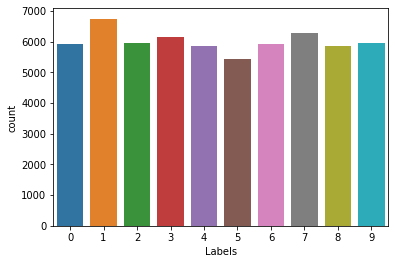

In [5]:
import seaborn as sns
import pandas as pd
Data = pd.DataFrame()
Data ['Labels'] = train_lb
sns.countplot(x = 'Labels' ,data = Data );

In [54]:
import random
num = 5
images,labels = zip(*random.sample(list(zip(train_img,train_lb)),num))
images = list(images)
labels = list(labels)

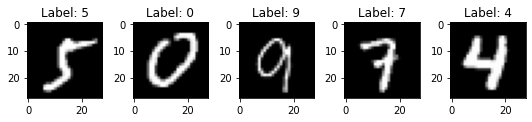

In [ ]:
num_row = 1
num_col = 5
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

## Part 2:

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 500), 
            nn.ReLU(),
            nn.Linear(500, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 30) 
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(30, 100),
            nn.ReLU(),
            nn.Linear(100, 200),
            nn.ReLU(),
            nn.Linear(200, 500),
            nn.ReLU(),
            nn.Linear(500, 28 * 28),
            nn.Sigmoid()
        )
    

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [7]:
model = Autoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [8]:
num_epochs = 10
outputs = list()
loss_list = list()
loss_valid_list = list()

for epoch in range(num_epochs):
    for (img, _) in train_data:
        img = img.reshape(-1, 28*28) 
        result = model.forward(img)
        loss = criterion(result, img)
        loss_list.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
    for (img, _) in test_data:
        img = img.reshape(-1, 28*28) 
        result = model.forward(img)
        loss_valid = criterion(result, img)
        loss_valid_list.append(loss_valid.item())

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, result))

Epoch:1, Loss:0.0352
Epoch:2, Loss:0.0276
Epoch:3, Loss:0.0233
Epoch:4, Loss:0.0222
Epoch:5, Loss:0.0210
Epoch:6, Loss:0.0199
Epoch:7, Loss:0.0191
Epoch:8, Loss:0.0173
Epoch:9, Loss:0.0169
Epoch:10, Loss:0.0165


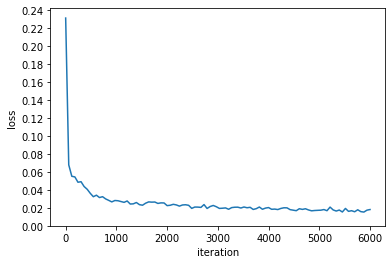

In [11]:
import numpy as np
iter = np.linspace(0,len(loss_list),100)
plt.plot(iter, loss_list[::60]);
plt.xlabel('iteration')
plt.ylabel('loss');
plt.yticks([0.02 * i for i in range(13)]);

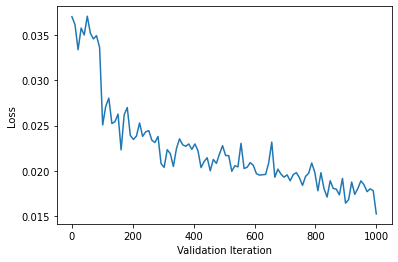

In [ ]:
import numpy as np
iter = np.linspace(0,len(loss_valid_list),100)
plt.plot(iter, loss_valid_list[::10]);
plt.xlabel('Validation Iteration');
plt.ylabel('Loss');

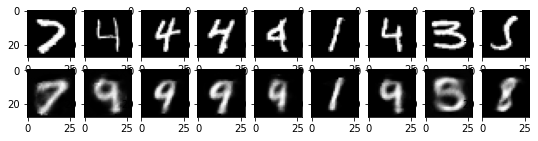

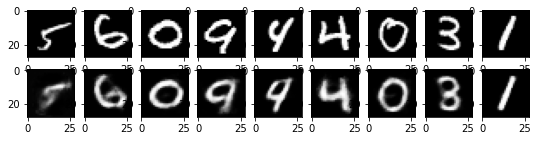

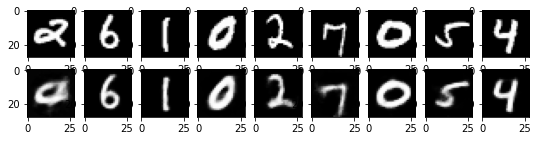

In [ ]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28,28) 
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        item = item.reshape(-1, 28,28) 
        plt.imshow(item[0])

# Part 3

In [12]:
class Classification(nn.Module):
    def __init__(self):
        super().__init__()        
        self.Neural_layers = nn.Sequential(
            nn.Linear(30, 20), 
            nn.ReLU(),
            nn.Linear(20, 15),
            nn.ReLU(),
            nn.Linear(15, 10),
            nn.Softmax()
        )
        

    def forward(self, x):
        Class = self.Neural_layers(x)
        return Class

    def predict(self,x):
        Classes = self.Neural_layers(x)
        predicted_label = Classes.argmax() 
        return predicted_label 

In [13]:
model_2 = Classification()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [14]:
num_epochs = 10
outputs = list()
loss_list = list()
Accuracy = list()
loss_valid_list = list()
Accuracy_val = list()
for epoch in range(num_epochs):
    for (img,lb) in train_data:
        correct = 0
        img = img.reshape(-1, 28*28) 
        encoded = model.encoder(img)
        result = model_2.forward(encoded)
        outputs.append(result)
        loss = criterion(result,lb)
        loss_list.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        for i in range(train_data.batch_size):
          correct += (result[i].argmax() == lb[i])

        accuracy = correct / len(result) * 100
        Accuracy.append(accuracy)

    for (img, lb) in test_data:
        correct = 0
        img = img.reshape(-1, 28*28)
        encoded = model.encoder(img)
        result = model_2.forward(encoded) 
        loss_valid = criterion(result, lb)
        loss_valid_list.append(loss_valid.item())

        for i in range(test_data.batch_size):
          correct += (result[i].argmax() == lb[i])

        accuracy = correct / len(result) * 100
        Accuracy_val.append(accuracy)
        

    print(f'Epoch:{epoch+1}, Loss:{(loss.item() / (train_data.batch_size)):.4f}, Accuracy:{accuracy}') 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch:1, Loss:0.0161, Accuracy:89.0
Epoch:2, Loss:0.0158, Accuracy:89.0
Epoch:3, Loss:0.0155, Accuracy:88.0
Epoch:4, Loss:0.0153, Accuracy:91.0
Epoch:5, Loss:0.0156, Accuracy:89.0
Epoch:6, Loss:0.0158, Accuracy:91.0
Epoch:7, Loss:0.0154, Accuracy:90.0
Epoch:8, Loss:0.0153, Accuracy:91.0
Epoch:9, Loss:0.0151, Accuracy:94.0
Epoch:10, Loss:0.0149, Accuracy:95.0


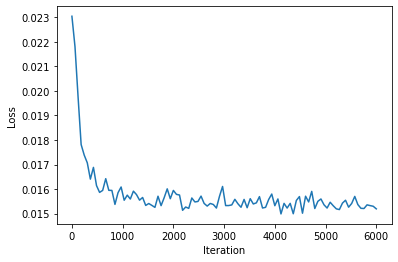

In [15]:
import numpy as np
iter = np.linspace(0,len(loss_list),100)
plt.plot(iter, np.array(loss_list[::60])/(train_data.batch_size));
plt.xlabel('Iteration');
plt.ylabel('Loss');

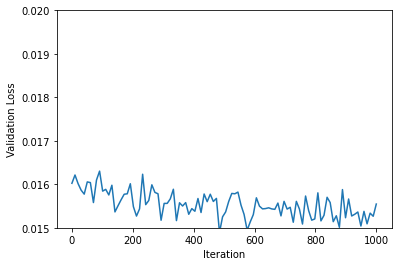

In [17]:
import numpy as np
iter = np.linspace(0,len(loss_valid_list),100)
plt.plot(iter, np.array(loss_valid_list[::10])/(train_data.batch_size));
plt.xlabel('Iteration');
plt.ylabel('Validation Loss');
plt.ylim(0.015,0.02);

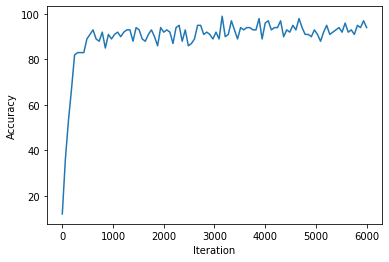

In [36]:
import numpy as np
iter = np.linspace(0,len(Accuracy),100)
plt.plot(iter, np.array(Accuracy[::60]));
plt.xlabel('Iteration');
plt.ylabel('Accuracy');

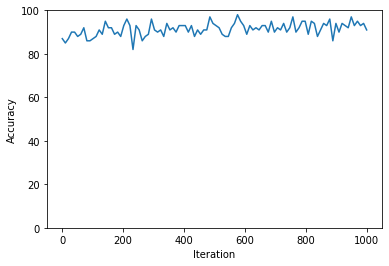

In [18]:
import numpy as np
iter = np.linspace(0,len(Accuracy_val),100)
plt.plot(iter, np.array(Accuracy_val[::10]));
plt.xlabel('Iteration');
plt.ylabel('Accuracy');
plt.ylim(0,100);

## Testing the model with test data

In [ ]:
outputs = list()
loss_list = list()
Accuracy = list()
predicted_test_lb = list()
actual_test_lb = list()

for (img,lb) in test_data:
  correct = 0
  img = img.reshape(-1, 28*28) 
  encoded = model.encoder(img)
  result = model_2.forward(encoded)
  outputs.append(result)

  for i in range(train_data.batch_size):
    correct += (result[i].argmax() == lb[i])
    predicted_test_lb.append(result[i].argmax())
    actual_test_lb.append(lb[i])

  accuracy = correct / len(result) * 100
  Accuracy.append(accuracy)
Average_accuracy = round(np.array(Accuracy).mean(),2)  

In [51]:
print('Average Accuracy For Test Data: {} %'.format(int(round(Average_accuracy))))   

Average Accuracy For Test Data: 93 %


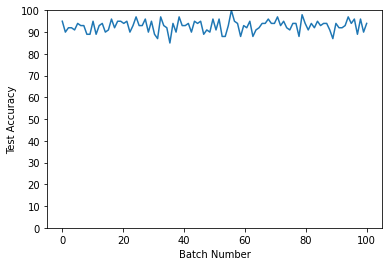

In [21]:
import numpy as np
iter = np.linspace(0,len(Accuracy),100)
plt.plot(iter, np.array(Accuracy));
plt.xlabel('Batch Number');
plt.ylabel('Test Accuracy');
plt.yticks([10 * i for i in range(11)]);
plt.ylim(0,100);

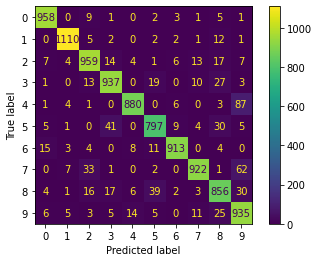

In [78]:
from sklearn.metrics import multilabel_confusion_matrix
import sklearn.metrics as metrics

confusion_matrix = metrics.confusion_matrix(actual_test_lb, predicted_test_lb)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0,1,2,3,4,5,6,7,8,9])

cm_display.plot()
plt.show()